In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, lxml
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
# import folium # map rendering library
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
import folium
from IPython.display import display

In [24]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source)

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [25]:
print(df.shape)
df


(103, 3)


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [26]:
df = df[df['Borough'] != 'Not assigned'].reset_index(drop = True)

In [27]:
df[df['Neighborhood'] == 'Not assigned'].shape[0]

0

Number of rows where Neighbourhood is "Not assigned" is 0

### Merging rows


In [28]:
postcodes = df['PostalCode'].values
boroughs = df['Borough'].values
neighs = df['Neighborhood'].values

#create a dictionary with keys as Postcode and Borough, keys of dictioaries are unique
dic = dict({(key1,key2): [] for key1, key2 in zip(postcodes, boroughs)})
print('Number of keys in the dictionary are: ', len(dic.keys()))

#filling the values of keys of dictionary
for postcode, borough, neigh in zip(postcodes,boroughs, neighs):
    key = (postcode, borough)
    dic[key].append(neigh)

df = pd.DataFrame(columns = ['Postal Code', 'Borough', 'Neighbourhood'])
for key, value in dic.items():
    postcode, borough, neig = key[0], key[1], value
    neig = ', '.join(neig)
    df = df.append({'Postal Code': postcode,
                     'Borough': borough,
                     'Neighbourhood': neig}, ignore_index = True)
print('Shape of final data is: ', df.shape)
df



Number of keys in the dictionary are:  103
Shape of final data is:  (103, 3)


,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [31]:
print('The final shape of the data is : {}'.format(df.shape))


The final shape of the data is : (103, 3)


## Adding longitude and latitude

In [37]:
latlong = pd.read_csv('Geospatial_Coordinates.csv')
latlong.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [38]:
df_lat_long = pd.merge(df, latlong, on = 'Postal Code')

In [43]:
df_lat_long.head(12)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


## Exploring and clustering

In [44]:
address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 43.6534817, -79.3839347.


In [46]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_lat_long['Latitude'], df_lat_long['Longitude'], df_lat_long['Borough'], df_lat_long['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [47]:
print('Total number of Borough = ', len(df['Borough'].unique()))

Toatl number of Borough =  15


In [50]:
downtown_toronto = df_lat_long[df_lat_long['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
print(downtown_toronto.shape)
downtown_toronto.head()

(17, 5)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383


In [93]:
address = 'Downtown Toronto ,Toronto, Ontario'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of New York using latitude and longitude values
map_dwontown = folium.Map(location=[latitude, longitude], zoom_start= 11)

# add markers to map
for lat, lng, borough, neighborhood in zip(downtown_toronto['Latitude'], downtown_toronto['Longitude'], 
                                           downtown_toronto['Borough'], downtown_toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dwontown)  
    
display(map_dwontown)


In [54]:
#definig the latitude and longitude using above dataframe
lat = downtown_toronto.loc[0, 'Latitude'] # neighborhood latitude value
lon = downtown_toronto.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = downtown_toronto.loc[0, 'Neighbourhood'] # neighborhood name
print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, lat, lon))

CLIENT_ID = 'your_client_id' # your Foursquare ID
CLIENT_SECRET = 'your_client_secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100
radius =1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, lat,lon, radius, LIMIT)

# gettig the venues data form Forsquare API in json format
results = requests.get(url).json()
results

Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


{'meta': {'code': 200, 'requestId': '61ad55f36aa6d3461253c276'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-53b8466a498e83df908c3f21-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1e0931735',
         'name': 'Coffee Shop',
         'pluralName': 'Coffee Shops',
         'primary': True,
         'shortName': 'Coffee Shop'}],
       'id': '53b8466a498e83df908c3f21',
       'location': {'address': '368 King St E',
        'cc': 'CA',
        'city': 'Toronto',
        'country': 'Canada',
        'crossStreet': 'at Trinity St',
        'distance': 122,
        'formattedAddress': ['368 King St E (at Trinity St)',
         'Toronto ON',
         'Canada'],
        'labeledLatLngs': [{'labe

In [55]:
venues = results['response']['groups'][0]['items']
venues_df = json_normalize(venues) # flatten JSON
venues_df.head(2)

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.postalCode,venue.location.neighborhood,venue.venuePage.id
0,e-0-53b8466a498e83df908c3f21-0,0,"[{'summary': 'This spot is popular', 'type': '...",53b8466a498e83df908c3f21,Tandem Coffee,368 King St E,at Trinity St,43.653559,-79.361809,"[{'label': 'display', 'lat': 43.65355870959944...",122,CA,Toronto,ON,Canada,"[368 King St E (at Trinity St), Toronto ON, Ca...","[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",0,[],NaN,NaN,NaN
1,e-0-54ea41ad498e9a11e9e13308-1,0,"[{'summary': 'This spot is popular', 'type': '...",54ea41ad498e9a11e9e13308,Roselle Desserts,362 King St E,Trinity St,43.653447,-79.362017,"[{'label': 'display', 'lat': 43.65344672305267...",143,CA,Toronto,ON,Canada,"[362 King St E (Trinity St), Toronto ON M5A 1K...","[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",0,[],M5A 1K9,NaN,NaN


In [56]:
# filter columns
cols = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
venues_df = venues_df.loc[:, cols]
# to show whole text in columns in dataframe python: https://stackoverflow.com/a/25352191
pd.set_option("display.max_colwidth" , -1)
venues_df.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Tandem Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}]",43.653559,-79.361809
1,Roselle Desserts,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}]",43.653447,-79.362017
2,Cooper Koo Family YMCA,"[{'id': '52e81612bcbc57f1066b7a37', 'name': 'Distribution Center', 'pluralName': 'Distribution Centers', 'shortName': 'Distributor', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/default_', 'suffix': '.png'}, 'primary': True}]",43.653249,-79.358008
3,Body Blitz Spa East,"[{'id': '4bf58dd8d48988d1ed941735', 'name': 'Spa', 'pluralName': 'Spas', 'shortName': 'Spa', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/spa_', 'suffix': '.png'}, 'primary': True}]",43.654735,-79.359874
4,Impact Kitchen,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'Restaurant', 'pluralName': 'Restaurants', 'shortName': 'Restaurant', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}]",43.656369,-79.356980


In [57]:
# reset set option dataframe: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.reset_option.html
pd.reset_option('display.max_colwidth')

In [58]:
venues_df['venue.categories'] = venues_df.apply(lambda x: x['venue.categories'][0]['name'], axis=1)
venues_df.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Tandem Coffee,Coffee Shop,43.653559,-79.361809
1,Roselle Desserts,Bakery,43.653447,-79.362017
2,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
3,Body Blitz Spa East,Spa,43.654735,-79.359874
4,Impact Kitchen,Restaurant,43.656369,-79.356980


In [59]:
# clean columns
venues_df.columns = [col.split(".")[-1] for col in venues_df.columns]
print('{} Venues are returned for: {}'.format(venues_df.shape[0], neighborhood_name))
venues_df.head()

100 Venues are returned for: Regent Park, Harbourfront


,name,categories,lat,lng
0,Tandem Coffee,Coffee Shop,43.653559,-79.361809
1,Roselle Desserts,Bakery,43.653447,-79.362017
2,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
3,Body Blitz Spa East,Spa,43.654735,-79.359874
4,Impact Kitchen,Restaurant,43.656369,-79.356980


In [60]:
def get_near_by_venues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, 
                             v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue in venues_list for item in venue])
    nearby_venues.columns = ['Neighbourhood','Neighbourhood Latitude', 'Neighbourhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return nearby_venues

In [61]:
donwntown_venues = get_near_by_venues(names=downtown_toronto['Neighbourhood'],latitudes=downtown_toronto['Latitude'],
                                   longitudes=downtown_toronto['Longitude'])

In [62]:
print(donwntown_venues.shape)
donwntown_venues.head()

(1115, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [63]:
print('There are {} uniques categories.'.format(len(donwntown_venues['Venue Category'].unique())))
print('\n\nVenues returned for each neighbourhood: ')
donwntown_venues.groupby('Neighbourhood')['Venue'].count()

There are 203 uniques categories.


Venues returned for each neighbourhood: 


Neighbourhood
Berczy Park                                                                                                    58
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport     16
Central Bay Street                                                                                             69
Christie                                                                                                       15
Church and Wellesley                                                                                           81
Commerce Court, Victoria Hotel                                                                                100
First Canadian Place, Underground city                                                                        100
Garden District, Ryerson                                                                                      100
Harbourfront East, Union Station, Toronto Islands                         

In [64]:
# one hot encoding of venue categories columns:https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
downtown_onehot = pd.get_dummies(donwntown_venues[['Venue Category']], prefix= "", prefix_sep= " ")

# # add neighborhood column back to dataframe
downtown_onehot['Neighbourhood'] = donwntown_venues['Neighbourhood'] 
# move neighborhood column to the first column
fixed_columns = [downtown_onehot.columns[-1]] + list(downtown_onehot.columns[:-1])
downtown_onehot = downtown_onehot[fixed_columns]
print(downtown_onehot.shape)
downtown_onehot.head()

(1115, 204)


,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,...,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Strip Club,Summer Camp,Supermarket,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
downtown_grouped = downtown_onehot.groupby('Neighbourhood').mean().reset_index()
print(downtown_grouped.shape)
downtown_grouped.head()

(17, 204)


,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,...,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Strip Club,Summer Camp,Supermarket,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.017241,0.0,0.0,0.017241,0.000000,0.0,0.0,0.0,0.000000,0.017241,0.034483,0.000000,0.0,0.0,0.017241,0.017241,0.0,0.034483,0.0,0.0,0.017241,0.0000,0.000000,0.0000,0.0,0.017241,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.034483,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.017241,0.0,0.0,0.017241,0.000000,0.000000,0.0,0.000000,0.017241,0.0,0.0,0.0,0.017241,0.000000,0.000000,0.0,0.0,0.017241,0.0,0.0,0.0,0.0,0.000000
1,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0625,0.000000,0.0625,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.062500,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,Central Bay Street,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.0,0.0,0.000000,0.014493,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.014493,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0000,0.014493,0.0000,0.0,0.000000,0.0,0.014493,0.0,0.028986,0.000000,...,0.0,0.000000,0.028986,0.000000,0.086957,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.028986,0.0,0.000000,0.0,0.0,0.014493,0.000000,0.000000,0.0,0.014493,0.000000,0.0,0.0,0.0,0.043478,0.000000,0.000000,0.0,0.0,0.014493,0.0,0.0,0.0,0.0,0.014493
3,Christie,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.066667,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0000,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,Church and Wellesley,0.012346,0.012346,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.012346,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.012346,0.0,0.0,0.000000,0.0000,0.012346,0.0000,0.0,0.012346,0.0,0.024691,0.0,0.012346,0.012346,...,0.0,0.012346,0.000000,0.012346,0.000000,0.0,0.012346,0.000000,0.0,0.0,0.0,0.012346,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.012346,0.012346,0.012346,0.0,0.061728,0.000000,0.0,0.0,0.0,0.012346,0.024691,0.012346,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.024691


In [66]:
num_top_venues = 5

for hood in downtown_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = downtown_grouped[downtown_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    
    #first rows is not usefull it has only Neighbourhood and Neighbourhood-name, so drop this row
    temp = temp.iloc[1:]
    temp['freq'] = round(temp['freq'].astype(float),2)# converting into float type and # taking round values
    temp = temp.sort_values('freq', ascending=False).reset_index(drop=True) # sorting the dataframe by 'freq' in decreasing order
    print(temp.head(num_top_venues))
    print('\n')

----Berczy Park----
             venue  freq
0      Coffee Shop  0.07
1   Farmers Market  0.03
2         Pharmacy  0.03
3      Cheese Shop  0.03
4     Cocktail Bar  0.03


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
               venue  freq
0    Airport Service  0.19
1     Airport Lounge  0.12
2   Airport Terminal  0.12
3    Harbor / Marina  0.06
4      Boat or Ferry  0.06


----Central Bay Street----
              venue  freq
0       Coffee Shop  0.17
1    Sandwich Place  0.09
2              Café  0.06
3   Thai Restaurant  0.04
4      Burger Joint  0.03


----Christie----
            venue  freq
0   Grocery Store  0.27
1            Café  0.20
2            Park  0.13
3     Coffee Shop  0.13
4     Candy Store  0.07


----Church and Wellesley----
                  venue  freq
0           Coffee Shop  0.06
1      Sushi Restaurant  0.06
2   Japanese Restaurant  0.06
3               Gay Bar  0.05
4            Restauran

In [67]:
def return_most_common_venues(row, num_top_venues):
    row = row.iloc[1:]
    row_sorted = row.sort_values(ascending=False)
    
    return row_sorted.index.values[0:num_top_venues]

In [68]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Neighbourhood'] = downtown_grouped['Neighbourhood']

for ind in np.arange(downtown_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(downtown_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Pharmacy,Cheese Shop,Seafood Restaurant,Farmers Market,Bakery,Restaurant,Pub,Beer Bar,Cocktail Bar
1,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Harbor / Marina,Boat or Ferry,Rental Car Location,Boutique,Plane,Sculpture Garden,Airport
2,Central Bay Street,Coffee Shop,Sandwich Place,Café,Thai Restaurant,Burger Joint,Spa,Salad Place,Japanese Restaurant,Italian Restaurant,Department Store
3,Christie,Grocery Store,Café,Park,Coffee Shop,Baby Store,Nightclub,Candy Store,Restaurant,Dessert Shop,Electronics Store
4,Church and Wellesley,Japanese Restaurant,Coffee Shop,Sushi Restaurant,Gay Bar,Restaurant,Yoga Studio,Pub,Grocery Store,Hotel,Café


In [71]:
downtown_grouped

,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,...,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Strip Club,Summer Camp,Supermarket,Sushi Restaurant,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.017241,0.000000,0.00,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.017241,0.034483,0.000000,0.000000,0.00,0.017241,0.017241,0.000000,0.034483,0.000000,0.000000,0.017241,0.0000,0.000000,0.0000,0.00,0.017241,0.00,0.000000,0.00,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.034483,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.017241,0.00,0.000000,0.017241,0.000000,0.000000,0.00,0.000000,0.017241,0.000000,0.00,0.000000,0.017241,0.000000,0.000000,0.00,0.00,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000
1,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0625,0.000000,0.0625,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.062500,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Central Bay Street,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,0.000000,0.014493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014493,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.014493,0.0000,0.00,0.000000,0.00,0.014493,0.00,0.028986,0.000000,...,0.00,0.000000,0.028986,0.000000,0.086957,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.028986,0.00,0.000000,0.00,0.000000,0.014493,0.000000,0.000000,0.00,0.014493,0.000000,0.000000,0.00,0.000000,0.043478,0.000000,0.000000,0.00,0.00,0.014493,0.000000,0.000000,0.000000,0.000000,0.014493
3,Christie,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Church and Wellesley,0.012346,0.012346,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.012346,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.012346,0.000000,0.000000,0.000000,0.0000,0.012346,0.

## Applying the elbow method

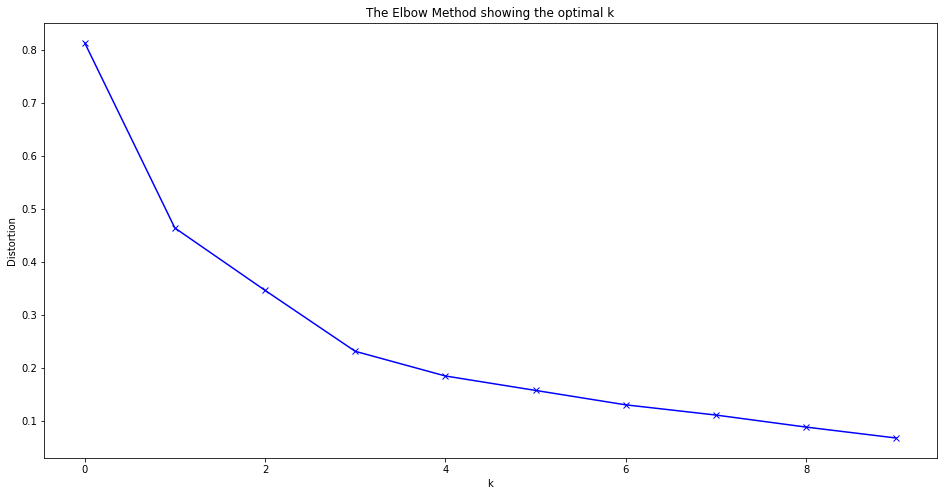

In [75]:
distortions = []
X = downtown_grouped.drop('Neighbourhood', axis = 1)
for i in range(1, 11):
  kmeans = KMeans(n_clusters = i, random_state = 0)
  kmeans.fit(X)
  distortions.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(range(10), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The optimal number of cluster is 4


In [88]:
kmeans = KMeans(n_clusters = 4, random_state = 0)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=0)

In [89]:
# add clustering labels
venues_sorted['Cluster_Labels']=  kmeans.labels_

downtown_toronto_merged = downtown_toronto
# merge top venues_sorted with toronto_data
downtown_toronto_merged = downtown_toronto_merged.join(venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

downtown_toronto_merged

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Coffee Shop,Bakery,Pub,Café,Park,Breakfast Spot,Theater,Yoga Studio,Mexican Restaurant,Restaurant,2
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Cosmetics Shop,Bubble Tea Shop,Thai Restaurant,Electronics Store,Bookstore,Hotel,2
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,Coffee Shop,Restaurant,Café,Hotel,Cocktail Bar,Beer Bar,American Restaurant,Cosmetics Shop,Farmers Market,Italian Restaurant,2
3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,Coffee Shop,Pharmacy,Cheese Shop,Seafood Restaurant,Farmers Market,Bakery,Restaurant,Pub,Beer Bar,Cocktail Bar,2
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,Coffee Shop,Sandwich Place,Café,Thai Restaurant,Burger Joint,Spa,Salad Place,Japanese Restaurant,Italian Restaurant,Department Store,2
5,M6G,Downtown Toronto,Christie,43.669542,-79.422564,Grocery Store,Café,Park,Coffee Shop,Baby Store,Nightclub,Candy Store,Restaurant,Dessert Shop,Electronics Store,1
6,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,Coffee Shop,Hotel,Café,Gym,Clothing Store,Restaurant,Bar,Thai Restaurant,Steakhouse,Sushi Restaurant,2
7,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Coffee Shop,Aquarium,Hotel,Café,Scenic Lookout,Brewery,Fried Chicken Joint,Restaurant,History Museum,Sporting Goods Shop,2
8,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,Salad Place,American Restaurant,Lounge,2
9,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Coffee Shop,Café,Restaurant,Hotel,Gym,Cocktail Bar,Italian Restaurant,Asian Restaurant,Deli / Bodega,Seafood Restaurant,2


In [90]:
venues_sorted['Cluster_Labels']

0     2
1     3
2     2
3     1
4     2
5     2
6     2
7     2
8     2
9     2
10    2
11    2
12    0
13    2
14    2
15    2
16    2
Name: Cluster_Labels, dtype: int32

In [94]:
# create map
map_clusterd = folium.Map(location=[latitude, longitude], zoom_start=11)
k = 3
# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_toronto_merged['Latitude'], downtown_toronto_merged['Longitude'],
                                  downtown_toronto_merged['Neighbourhood'], downtown_toronto_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusterd)
       
display(map_clusterd)